Note: We ran this notebook on AWS 'g4dn.4xlarge' EC2 instance with Ubuntu's Deep Learning AMI.

# Capstone Project: Skin Lesion Classification and Diagnosis
## Notebook 4b: Modelling and Evaluation (Diagnosis Classifier) with Conclusion

### Table of Contents
- [Problem Statement](#Problem-Statement)
- [Importing Libraries](#Importing-Libraries)
- [Functions](#Functions)
- [Metrics](#Metrics)
- [Loading Data](#Loading-Data)
- [Baseline](#Baseline)
- [Convolutional Neural Network (CNN) Model](#Convolutional-Neural-Network-(CNN)-Model)
- [CNN Model Evaluation](#CNN-Model-Evaluation)
- [Final Model Evaluation](#Final-Model-Evaluation)
- [Confusion Matrix](#Confusion-Matrix)
- [Classification Metrics](#Classification-Metrics)
- [Studying Wrong Predictions](#Studying-Wrong-Predictions)

### Problem Statement

Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Even though dermoscopy, a skin imaging modality, has demonstrated improvement for the diagnosis of skin cancer compared to unaided visual inspection<sup>[[1]](https://challenge2019.isic-archive.com/)</sup>, numerous cases of benign lesions are still being diagnosed as malicious and vice versa<sup>[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6394090/)</sup>. Every year, poor diagnostic errors adds an estimated $673 million in overall cost to manage the disease<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>.

In this project, we aim to improve the diagnosis rate of skin cancer through the classification of skin lesions for dermatologists working at hospitals or skin clinics in Singapore, who will need experience or expertise in diagnosing skin cancer before they can accurately identify and diagnose lesions upon visual and dermoscopy inspection<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>. This will be done through the classification of skin lesion dermoscopy images, in which we will predict two important tasks through the usage of Convolutional Neural Network models: <br>
1. a specific skin lesion diagnosis, and <br>
2. whether the lesion is malignant, benign, or pre-cancerous. <br>

The model will be evaluated based on its accuracy, followed by its recall rate since we are looking to minimise false negatives. Ultimately, we aim to get as close to a real evaluation of a dermatologist as possible: predicting the type of skin lesion; and whether the lesion is malignant, pre-cancerous or benign from dermoscopy images. With our models, we hope to aid dermatologists in their decision-making process of diagnosing skin lesions, hence allowing them to improve their diagnostic accuracy and come up with appropriate treatments for patients with skin lesions and/or cancers.

### Importing Libraries

In [1]:
#importing libraries
import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score

np.random.seed(28)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Functions

In [4]:
#creating function that plots the history of models (with the history saved as a dataframe)
def plot_graph_from_dataframe(model, metric, metric_name, val_metric_name, baseline=0):
    #Set figure size
    plt.figure(figsize=(8,6))
    #Generate line plot of training, validation metric over epochs
    plt.plot(model[metric], label=metric_name)
    plt.plot(model['val_' + metric], label=val_metric_name)
    
    #Insert baseline if there's any baseline stated
    if baseline>0:
        plt.axhline(y=baseline, linewidth=1, color='r', linestyle = '--', label = 'Baseline')
        
    plt.legend(fontsize=10)
    #Set title
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title('Training and Validation ' + metric_name + ' by Epoch', fontsize = 12);

In [73]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, title, normalize=False, cmap=plt.cm.Blues):

    #compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #convert to percentage if normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #We want to show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Metrics

In [28]:
#creating get_recall function that computes overall macro-average recall rate
#and also prints the recall rate for each individual class (if print_ind_classes=True)

def get_recall(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    
    #macro average recall score
    overall_recall = np.mean(recall)
    
    #only print recall rate for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_recall = recall[x]
            class_name = classes[x]
            print(f"Recall rate for {class_name}: {round(class_recall,4)}")
        print("")
    return overall_recall

In [29]:
#creating get_precision function that computes overall macro-average precision rate
#and also prints the precision rate for each individual class (if print_ind_classes=True)

def get_precision(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    #macro average precision score
    overall_precision = np.mean(precision)
    
    #only print precision rate for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_precision = precision[x]
            class_name = classes[x]
            print(f"Precision rate for {class_name}: {round(class_precision,4)}")
        print("")
        
    return overall_precision

In [30]:
#creating get_f1_score function that computes overall macro-average f1 score
#and also prints the f1 score for each individual class (if print_ind_classes=True)

def get_f1_score(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    
    #macro average f1 score
    overall_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    
    #only print f1 score for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_precision = precision[x]
            class_recall = recall[x]
            class_name = classes[x]
            class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall)
            print(f"F1 Score for {class_name}: {round(class_f1,4)}")
        print("")
        
    return overall_f1

### Loading data

In [2]:
#download link of X_train/X_smote: https://bit.ly/x-smote-diagnosis
#download link of X_test, X_val: https://bit.ly/x-test-x-val-diagnosis

#loading image data for X (X_smote) and y (y_smote)
X_train = np.load('./datasets/npy/diagnosis/X_smote_diagnosis_284.npy')
y_train = np.load('./datasets/npy/diagnosis/y_smote_diagnosis_284.npy')

#loading image data for X_test and y_test
X_test = np.load('./datasets/npy/diagnosis/X_test_diagnosis_284.npy')
y_test = np.load('./datasets/npy/diagnosis/y_test_diagnosis_284.npy')

#loading image data for X_val and y_val
X_val = np.load('./datasets/npy/diagnosis/X_val_diagnosis_284.npy')
y_val = np.load('./datasets/npy/diagnosis/y_val_diagnosis_284.npy')

In [8]:
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_val dataset: ", X_val.shape)
print("y_val dataset: ", y_val.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (12240, 284, 284, 3)
y_train dataset:  (12240, 3)
X_val dataset:  (2055, 284, 284, 3)
y_val dataset:  (2055, 3)
X_test dataset:  (2056, 284, 284, 3)
y_test dataset:  (2056, 3)


## Baseline

In a fairly similar 3-way classification task, an accuracy rate of 65.78% was attained by Swedish dermatologists when detecting skin cancer<sup>[[11]](https://www.diva-portal.org/smash/get/diva2:1214297/FULLTEXT01.pdf)</sup>. Similarly, a recall rate of 49.2% is attained by dermatologists and plastic surgeons on detecting skin cancer in a study done in Southern Queensland<sup>[[12]](https://wiki.cancer.org.au/skincancerstats/Detection_and_screening)</sup>. 

Hence, an accuracy rate of 0.6578 and a recall rate of 0.4920 are both set as the baseline score for both metrics.

## Convolutional Neural Network (CNN) Model

Just like what have been done in Notebook 3a, the complexity of the model was gradually increased and the parameters were tuned for the best performance by looking at the loss and accuracy metrics of the validation data (in relation to the training data). 
The same methods relating to Batch Normalization, Dropout and GlobalMaxPooling2D layers were also applied to the model being trained for this classification task. Similarly, the ReduceLROnPlateau callback feature (with an initial learning rate of 0.0001) was also utilised in this model.

In [50]:
model = Sequential()

#Input layer: Convolution layer 1 with padding
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding = 'same', input_shape=(284,284,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution 2
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution 3
model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution 4
model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#BN and GlobalMaxPooling2D before putting it into hidden layer
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())

#Hidden layer
model.add(Dense(72, activation='relu'))
model.add(Dropout(0.4))

#Output Layer
model.add(Dense(3, activation='softmax'))

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 284, 284, 16)      1216      
_________________________________________________________________
batch_normalization_21 (Batc (None, 284, 284, 16)      64        
_________________________________________________________________
activation_17 (Activation)   (None, 284, 284, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 142, 142, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 140, 140, 32)      4640      
_________________________________________________________________
batch_normalization_22 (Batc (None, 140, 140, 32)      128       
_________________________________________________________________
activation_18 (Activation)   (None, 140, 140, 32)     

In [52]:
#utilising ReduceLROnPlateau, with factor if 0.1 if val_loss stops decreasing for 5 epochs
#minimum learning rate the model can decrease to is 0.00001
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [53]:
#utilising ModelCheckpoint to get best weights
filepath="./weights/diagnosis/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [54]:
model.compile(optimizer=Adam(lr=0.0001), #set learning rate of 0.0001
              loss='categorical_crossentropy', metrics=['accuracy']) 
            #inserting accuracy metric for model evaluation later

In [55]:
#run for 25 epochs with batch size of 32
cnn_model = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32,
                      callbacks=[rlrop, checkpoint])


Train on 12240 samples, validate on 2055 samples
Epoch 1/25
12240/12240 [==============================] - 59s 5ms/step - loss: 1.2245 - accuracy: 0.5547 - val_loss: 2.6947 - val_accuracy: 0.0988

Epoch 00001: val_accuracy improved from -inf to 0.09878, saving model to ./weights/diagnosis/weights-improvement-01-0.10.hdf5
Epoch 2/25
12240/12240 [==============================] - 58s 5ms/step - loss: 0.7446 - accuracy: 0.6619 - val_loss: 0.6909 - val_accuracy: 0.7212

Epoch 00002: val_accuracy improved from 0.09878 to 0.72117, saving model to ./weights/diagnosis/weights-improvement-02-0.72.hdf5
Epoch 3/25
12240/12240 [==============================] - 58s 5ms/step - loss: 0.6811 - accuracy: 0.6941 - val_loss: 0.5891 - val_accuracy: 0.7382

Epoch 00003: val_accuracy improved from 0.72117 to 0.73820, saving model to ./weights/diagnosis/weights-improvement-03-0.74.hdf5
Epoch 4/25
12240/12240 [==============================] - 58s 5ms/step - loss: 0.6375 - accuracy: 0.7208 - val_loss: 0.7080

In [61]:
#save history to dataframe
cnn_model_history =  pd.DataFrame(cnn_model.history)

In [62]:
#export as smote_cnn_model_history csv
cnn_model_history.to_csv('./datasets/history/diagnosis/4b_smote_cnn_model_history.csv', index=False)

In [63]:
#save model and architecture to single file
model.save("./model/diagnosis_classifier/4b_smote_model_cnn.h5")
print("Saved model to disk")

Saved model to disk


### CNN Model Evaluation

#### Plotting loss and accuracy over epochs

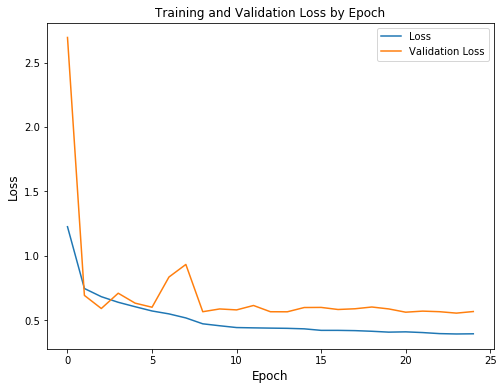

In [64]:
#plotting train and validation loss over epoch
plot_graph_from_dataframe(cnn_model_history, 'loss', 'Loss', 'Validation Loss')

Text(0.5, 1.0, 'Learning Rate by Epoch')

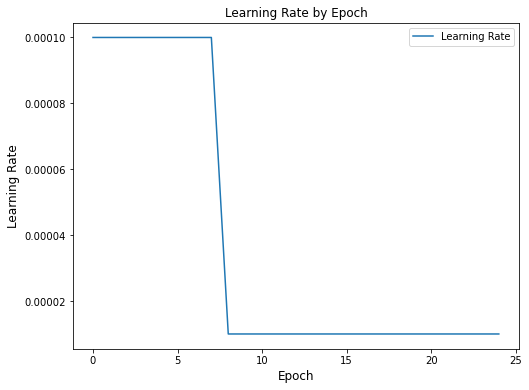

In [6]:
#Plot learning rate over epoch to see if it changes

#set figure size
plt.figure(figsize=(8,6))
#Generate line plot learning rate epochs
plt.plot(cnn_model_history['lr'], label='Learning Rate')
plt.legend(fontsize=10)
#Set title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate by Epoch', fontsize = 12)

Similar to the train and validation loss curve plotted in notebook 4a, we can also see a somewhat similar trend in our plot, where the validation seems to be increasing from the 4th to 8th epoch before decreasing at the 9th epoch and reaching a plateau of around 0.55. This sudden decrease in validation also happened due to the decrease in the learning rate by a factor of 0.1 at the 9th epoch as shown above (from ReduceLROnPlateau). This shows that the learning rate has a relatively significant impact in the model's performance for both models (in notebook 4a and 4b).

As for the training loss curve, it seems to drop before reaching a plateau of 0.40. 

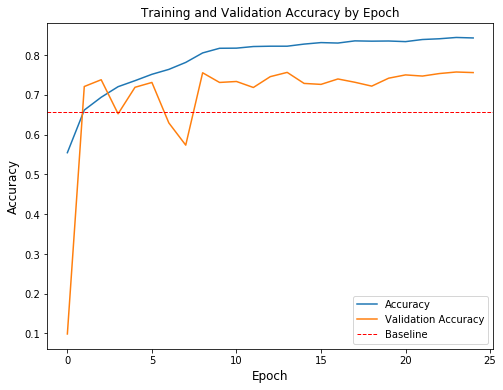

In [65]:
#plotting train and validation accuracy over epoch
#with baseline accuracy score of 0.6578
plot_graph_from_dataframe(cnn_model_history, 'accuracy', 'Accuracy', 'Validation Accuracy', 0.6578)

#### Validation Accuracy and Recall

In [8]:
#load model if required
model = load_model('./model/diagnosis_classifier/4b_smote_model_cnn.h5') 

In [9]:
#loading our model's best weights
model.load_weights("./weights/diagnosis/weights-improvement-24-0.76.hdf5")

In [128]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

65/65 [==============================] - 61s 935ms/step - loss: 0.5533 - accuracy: 0.7577


In [39]:
print('Val Accuracy:', round(val_accuracy,4))

Val Accuracy: 0.7577


In [26]:
#making predictions for validation set
y_pred_val = np.argmax(model.predict(X_val), axis=-1)
y_true_val = np.argmax(y_val, axis=1)

In [48]:
#calculate recall for val
val_avg_recall_rate = get_recall(y_true_val, y_pred_val, classes=False, no_of_classes=7, print_ind_classes=False)
print('Val\'s Macro Average Recall Rate:', round(val_avg_recall_rate,4))

Val's Macro Average Recall Rate: 0.6255


Both the accuracy and the macro-average recall rates for our CNN model have exceeded the baseline score, as evident by model's test accuracy rate of 0.7577 surpassing the baseline score of 65.78%, and model's average recall score of 0.6355 exceeding baseline score of 0.492.

## Final Model Evaluation

### Test Accuracy and Recall

In [75]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

2056/2056 [==============================] - 3s 1ms/step


In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

65/65 [==============================] - 57s 883ms/step - loss: 0.5331 - accuracy: 0.7636


In [76]:
#calculates the accuracy rate
print('Test Accuracy:', round(test_accuracy,4))

Test Accuracy: 0.7636


In [10]:
#Making predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=1)

In [47]:
#calculate recall for test set
test_avg_recall_rate = get_recall(y_true, y_pred, classes=False, no_of_classes=7, print_ind_classes=False)
print('Test\'s Macro Average Recall Rate:', round(test_avg_recall_rate, 4))

Test's Macro Average Recall Rate: 0.6443


In [54]:
print('Difference between Test and Val Accuracy:', abs(round(test_accuracy - val_accuracy,4)))
print('Difference between Test and Val Macro Average Recall Rate:', abs(round(test_avg_recall_rate - val_avg_recall_rate,4)))

Difference between Test and Val Accuracy: 0.006
Difference between Test and Val Macro Average Recall Rate: 0.0188


With a very small difference in accuracy and recall rates derived from our test and validation sets (0.006 for accuracy and 0.0188 for recall), this means that our model generalises well on our test set when compared to our validation set.

### Confusion Matrix

In [43]:
#listing down the class names
class_names=['benign', 'malignant', 'precancerous']

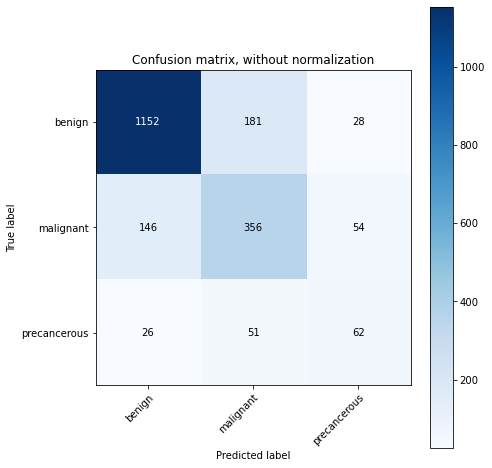

In [74]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

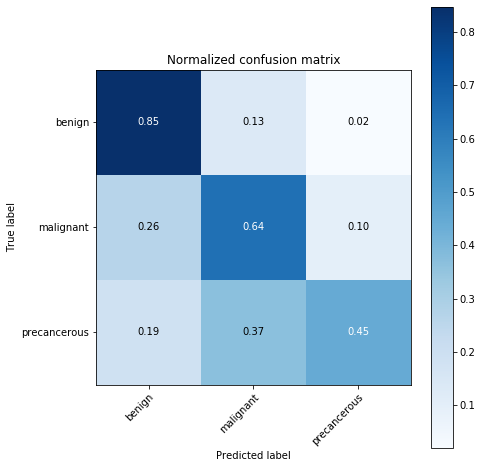

In [80]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

Our confusion matrix above illustrates that classes that were predicted less accurately by the model are the precancerous and malignant classes. Each class and their wrongly predicted classes (and percentage) are listed as follows:

|Class|Right Predictions|1st Misclassified Class|Percentage|2nd Misclassified Class|Percentage|
|:---|:---:|:---:|:---:|:---:|:---:|
|**Benign**|85%|Malignant|13%|Precancerous|2%|
|**Malignant**|64%|Benign|26%|Precancerous|10%|
|**Precancerous**|45%|Malignant|37%|Benign|19%|

A subset of the wrong predictions from the precancerous and malignant classes will be plotted and studied below under [Studying Wrong Predictions](#Studying-Wrong-Predictions).

### Classification Metrics

In [55]:
#to access values in the classification report
classification_dict = classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

#print classification report
classification = classification_report(y_true, y_pred, target_names=class_names, digits = 4)
print(classification)

              precision    recall  f1-score   support

      benign     0.8701    0.8464    0.8581      1361
   malignant     0.6054    0.6403    0.6224       556
precancerous     0.4306    0.4460    0.4382       139

    accuracy                         0.7636      2056
   macro avg     0.6354    0.6443    0.6395      2056
weighted avg     0.7688    0.7636    0.7660      2056



Let's study each of our classification metrics in further detail.

#### Accuracy rate

In [82]:
#get accuracy
acc_score = accuracy_score(y_true, y_pred)
print('Overall Accuracy Score:', round(acc_score,4))

Overall Accuracy Score: 0.7636


With a relatively high accuracy score of 0.7636, this means that our model managed to predict 77.29% of predictions correctly (from our test dataset) for our diagnosis classification.

#### Recall rate

In [59]:
#get individual classes and macro-averaged recall rate
recall = get_recall(y_true, y_pred, class_names, 3, print_ind_classes=True)
print("Overall Macro Average Recall rate:", round(recall, 4))
#print weighted recall rate
print("Overall Weighted Recall Rate:", round(classification_dict['weighted avg']['recall'], 4))

Recall rate for benign: 0.8464
Recall rate for malignant: 0.6403
Recall rate for precancerous: 0.446

Overall Macro Average Recall rate: 0.6443
Overall Weighted Recall Rate: 0.7636


A higher recall rate minimises the false negatives (type II error), since the recall rate computes the fraction of examples which were predicted to belong to a class (true positives) with respect to all of the examples that truly belong in the class (true positive and false negatives). 

With an average recall rate of 0.6443, this means that the model predicts close to 3.5 false negatives per 10 predictions. A higher percentage of false negatives are mostly from the malignant and precancerous classes, since the individual recall rates are 0.6403 and 0.446 respectively.
On the other hand, our recall rate for our majority class, benign lesion, is high at 0.8464.

With regards to the weighted recall rate, the recall rate is relatively high at 0.7636 since more weightage is given to the majority class.

#### Precision rate

In [60]:
#get individual classes and macro-averaged precision rate
precision = get_precision(y_true, y_pred, class_names, 3, print_ind_classes=True)
print("Overall Macro Average Precision rate:", round(precision,4))

#print weighted precision rate
print("Overall Weighted Precision rate:", round(classification_dict['weighted avg']['precision'],4))

Precision rate for benign: 0.8701
Precision rate for malignant: 0.6054
Precision rate for precancerous: 0.4306

Overall Macro Average Precision rate: 0.6354
Overall Weighted Precision rate: 0.7688


Similarly, a higher precision rate minimises the false positives (type I error), since the recall rate computes the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class (true positive and false positives).

With an average precision rate of 0.6354, this means that the model predicts close to 3.7 false positives per 10 predictions. A higher percentage of false positives are also mostly from the malignant and precancerous classes, since the individual precision rates are 0.6054 and 0.4306 respectively. Similarly, the precision rate for our benign class is high at 0.8701.

With regards to the weighted precision rate, the precision rate is relatively high at 0.7688 since more weightage is given to the majority class.

#### F1 Score

In [61]:
#get individual classes and macro-averaged f1 score
f1_score = get_f1_score(y_true, y_pred, class_names, 3, print_ind_classes=True)
print("Overall Macro Average F1 score:", round(f1_score,4))

#print weighted f1 rate
print("Overall Weighted F1 score:", round(classification_dict['weighted avg']['f1-score'], 4))

F1 Score for benign: 0.8581
F1 Score for malignant: 0.6224
F1 Score for precancerous: 0.4382

Overall Macro Average F1 score: 0.6398
Overall Weighted F1 score: 0.766


The F1 score is defined as the harmonic mean of the model’s precision and recall. With both precision and recall having similar scores, our model's F1 score is at 0.6398. Similarly the F1 scores for the two minority classes are lower, with malignant at a fair score of 0.6224 and precancerous at a lower score of 0.4382.
On the other hand, the F1 score for our benign class is high at 0.8581, which means that the model has a good balance between precision and recall for the benign class.

Once again, our weighted F1 score is relatively high at 0.7660 since more weightage is given to the majority class.

#### Cohen Kappa Score

In [165]:
#get cohen kappa score
cohen = cohen_kappa_score(y_true, y_pred)
print("Kappa Score:", round(cohen,4))

Kappa Score: 0.5192


With scores between 1 and 0, the Kappa Score measures the degree of agreement between the true values and predicted values with 1 representing perfect agreement and 0 representing chance agreement. This measure computes how much better our classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class<sup>[[9]](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c)</sup>. 

Our model has a kappa score of 0.5192, which means that our classifier model has moderate agreement between the true values and predicted values<sup>[[10]](https://thedatascientist.com/performance-measures-cohens-kappa-statistic/)</sup>, and hence performs moderately well as a classifier.

### Studying Wrong Predictions

With lower recall, precision and accuracy rates of the malignant and precancerous classes, we shall study several misclassified images from these two classes to determine the reasons behind the model's misclassification of these images.

In [11]:
### creating dataframe of predictions against actual label
predictions = [x for x in y_pred]
true_values = [x for x in y_true]

pred = pd.DataFrame(list(zip(predictions,true_values)), columns = ['predictions', 'actual_label'])
pred.head(5)

,predictions,actual_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [12]:
#exporting pred as diagnosis_pred.csv
pred.to_csv('./datasets/diagnosis_pred.csv', index=False)

In [13]:
#convert their values to their respective class
pred.actual_label = pred.actual_label.map({0: 'benign', 1: 'malignant', 2:'precancerous'})
pred.predictions = pred.predictions.map({0: 'benign', 1: 'malignant', 2:'precancerous'})
pred.head(5)

,predictions,actual_label
0,benign,benign
1,benign,benign
2,benign,benign
3,benign,benign
4,benign,benign


In [14]:
#wrong benign (ben) and malignant (mag) predictions for precancerous class
wrong_pc_preds_as_ben = pred[(pred['actual_label'] == 'precancerous') & (pred['predictions']=='benign')]
wrong_pc_preds_as_mal = pred[(pred['actual_label'] == 'precancerous') & (pred['predictions']=='malignant')]

#wrong benign (ben) and precancerous (pc) predictions for malignant class
wrong_mal_preds_as_pc = pred[(pred['actual_label'] == 'malignant') & (pred['predictions'] == 'precancerous')]
wrong_mal_preds_as_ben = pred[(pred['actual_label'] == 'malignant') & (pred['predictions'] == 'benign')]

#### Precancerous Lesions

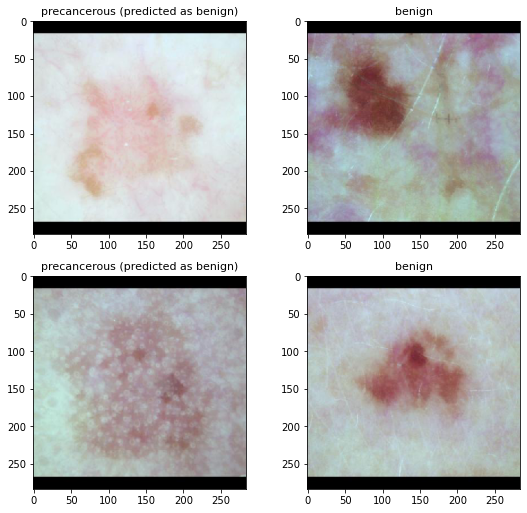

In [21]:
#plot images showing precancerous lesions being predicted as benign
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = wrong_pc_preds_as_ben.index[i]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('precancerous (predicted as benign)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'benign'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('benign', fontsize=11)
    
    count = count + 2

As seen above, the precancerous lesions that are misclassified as benign have common characteristics with true benign lesions, in which the lesions are flat and sometimes shaped similarly.

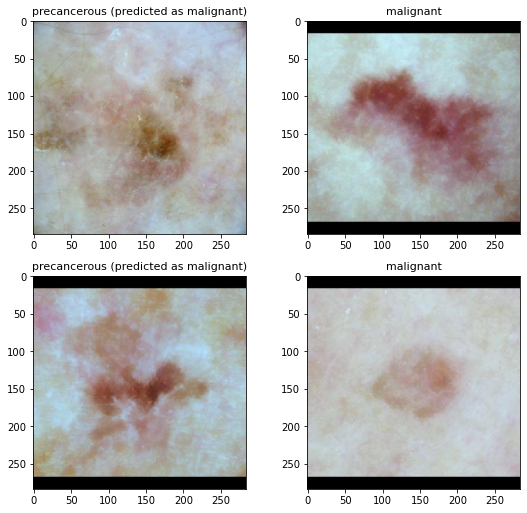

In [41]:
#plot images showing precancerous lesions being predicted as malignant
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = wrong_pc_preds_as_mal.index[i+24]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('precancerous (predicted as malignant)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'malignant'].index[i+27]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('malignant', fontsize=11)
    
    count = count + 2

On the other hand, the precancerous lesions that are misclassified as malignant do also share some common characteristics with truely malignant lesions: slightly reddish-brown looking lesions (after colour normalisation) with similar outlines and shapes.

#### Malignant Lesions

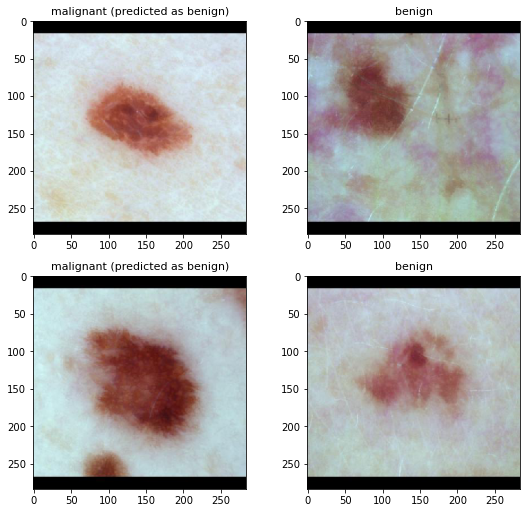

In [180]:
#plot images showing malignant lesions being predicted as benign
plt.figure(figsize = (9,18))
count = 1

for i in range(2):
    index = wrong_mal_preds_as_ben.index[i+1]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('malignant (predicted as benign)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'benign'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('benign', fontsize=11)
    
    count = count + 2


Malignant lesions that are wrongly predicted as benign share some common characteristics with true benign lesions, notably the shape and sizes of the lesions as well as the somewhat similar colour of the skin lesions (after colour normalisation).

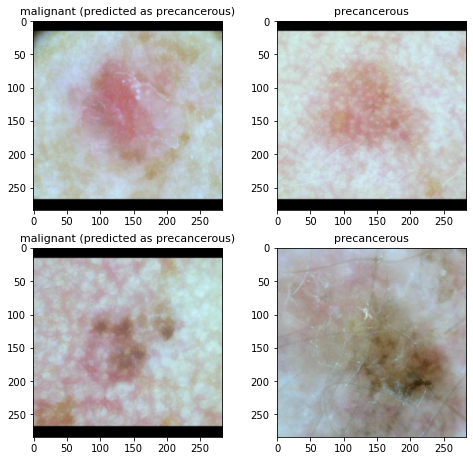

In [185]:
#plot images showing malignant lesions being predicted as precancerous
plt.figure(figsize = (8,16))
count = 1
for i in range(1,3):
    index = wrong_mal_preds_as_pc.index[i+2]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('malignant (predicted as precancerous)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'precancerous'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('precancerous', fontsize=11)
    
    count = count + 2

Similarly, several malignant lesions that are wrongly classified as precancerous do also share similar characteristics with truely precancerous lesions, particularly the colour, and shape of the lesions.

Looking at images from our misclassified predictions from both notebook 4a and 4b, and comparing them to images from their wrongly predicted labels, we can see that many of these lesions do share similar characteristics despite not being from the same class. 
This definitely corresponds with the actual misdiagnosis problem that many physicians and dermatologists, especially inexperienced ones, face in real life with relation to skin lesions and cancer. This problem arises from the fact that multiple benign lesions can mimic malignant lesions and vice versa, which can definitely be seen from our analysis above<sup>[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6394090/)</sup>.

## Recommendations and Conclusion

### Recommendations
Moving forward, the following recommendations can be considered:

1. With most misclassified images coming from minority classes, more data should be collected for those minority classes so that the model could learn more about the various types of colours, shapes, outlines and even size of the lesions from all these extra data collected. Even though SMOTE was used in this project to upsample the minority classes, using real images of the lesions from our minority classes would be much more useful for the model than synthetic samples created from SMOTE. <br>
(Note: When I added at least 200 extra images for the minority classes, the scores of each of our classification metric increased by at least two percentage points for both classification tasks.)<br>


2. Build a web application around our model so that the application could be used in-house securely at hospitals and skin clinics. Besides allowing dermatologists to make predictions with the web app, data could be also be added through this web app to further calibrate and improve our model (as explained above in the 1st point).


3. Additional metadata/medical data of patients (e.g. age, gender) or characteristics of lesions as noted down by the physicians (e.g. location of lesion) could be feeded to a fully connected network before merging the outputs of both sub-models (dense neural network and convolutional neural network models) for more detailed predictions and analysis.


4. The classification tasks of both models can be expanded to include other types of skin lesions, such as non-neoplastic lesions for diagnosis classification, as well as cystic lesions and more variants of melanoma lesions for skin lesion classification.

### Conclusion

With a moderately high accuracy of 70.53% for our skin lesion classification task and 76.36% for our diagnosis classification task, the overall performance of our CNN models for both classification tasks are moderately successful. Through there are still some room for improvement in their macro-averaged recall rates, both models have certainly surpassed the baseline score for their respective tasks, with macro-averaged recall rates all surpassing 60% (60.68% for skin lesion; 64.43% for diagnosis) and weighted averaged recall rates all exceeding 70% (70.53% for skin lesion; 76.36% for diagnosis). <br>
With both accuracy and recall rates being lower for the minority classes, adding more image data for the minority classes should be of utmost priority when training the model in the future. 

However, the models performed very well in terms of their accuracy, recall and precision rates for most benign skin lesions, especially for the diagnosis classification task, and hence could potentially serve as great classification models that can help improve the diagnosis rate specifically for benign skin lesions in the future.

Moving forward, the recommendations as stated above should be considered, which will not only calibrate the model for better performance through the usage of more data, but possibly also expand the model to train on other type of lesions so as to increase the model's use cases. By doing so, this model can serve as a better guide for dermatologists, aiding them in their decision-making process for patients with skin lesions or cancer, while continuously improving the clinical diagnostic accuracy of these skin specialists in the future.

### References:
https://challenge2019.isic-archive.com/<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6394090/<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/<br>
https://arxiv.org/pdf/1803.10417.pdf<br>
https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/<br>
https://arxiv.org/pdf/1502.03167.pdf/<br>
https://arxiv.org/abs/1801.05134/<br>
https://arxiv.org/pdf/1907.03220.pdf<br>
https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c<br>
https://thedatascientist.com/performance-measures-cohens-kappa-statistic/<br>
https://www.diva-portal.org/smash/get/diva2:1214297/FULLTEXT01.pdf/<br>
https://wiki.cancer.org.au/skincancerstats/Detection_and_screening/<br>